In [1]:
from SymbolicDSGE import ModelConfig, ModelParser, DSGESolver, FRED, Shock
from SymbolicDSGE.math_utils import HP_two_sided
import sympy as sp
from warnings import catch_warnings, simplefilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
conf = ModelParser("MODELS/POST82.yaml").get()

In [3]:
with catch_warnings():
    simplefilter(action="ignore")
    mat = sp.Matrix(conf.equations.model)
mat

Matrix([
[                             Eq(Pi(t), beta*Pi(t + 1) + kappa*x(t) + z(t))],
[                  Eq(x(t), -tau_inv*(-Pi(t + 1) + r(t)) + g(t) + x(t + 1))],
[Eq(r(t), e_R + rho_r*r(t - 1*1) + (1 - rho_r)*(psi_pi*Pi(t) + psi_x*x(t)))],
[                                          Eq(g(t), e_g + rho_g*g(t - 1*1))],
[                                          Eq(z(t), e_z + rho_z*z(t - 1*1))]])

In [4]:
sol = DSGESolver(conf)
comp = sol.compile(variable_order=conf.variables, n_state=3, n_exog=2)
conf.variables

[g, z, r, Pi, x]

In [5]:
solved = sol.solve(
    comp,
    steady_state=np.asarray([0.0, 0.0, 0.0, 0.0, 0.0], dtype=float),
    log_linear=False,
)

C:\Users\guney\Documents\GitHub\ThesisDraft\SymbolicDSGE\solver.py:435: ComplexWarning: Casting complex values to real discards the imaginary part
  p = np.asarray(mdl.p, dtype=float64)
C:\Users\guney\Documents\GitHub\ThesisDraft\SymbolicDSGE\solver.py:436: ComplexWarning: Casting complex values to real discards the imaginary part
  f = np.asarray(mdl.f, dtype=float64)


In [6]:
solved.policy.eig

array([0.27920118+0.j, 0.83000003+0.j, 0.84999992+0.j, 2.56517116+0.j,
       1.18470582+0.j])

In [7]:
params = {
    p.name: float(conf.calibration.parameters[p])
    for p in conf.parameters
    if p in conf.calibration.parameters
}

# state at time t
s = np.array([0.05, 0.077, 0.06])  # or any test state
P = solved.policy.p
F = solved.policy.f

# controls at time t (jump variables)
c = F @ s

cur = np.concatenate([s, c])

# expected next state (NO shock)
s1 = P @ s
c1 = F @ s1
fwd = np.concatenate([s1, c1])

res = solved.compiled.equations(fwd, cur, params)
print(res)

[np.complex128(-1.0494781432779376e-09+0j)
 np.complex128(8.938198320374013e-09+0j) -e_R - 4.89569941617557e-9
 1.52736900210781e-9 - e_g -e_z - 6.02379433833899e-9]


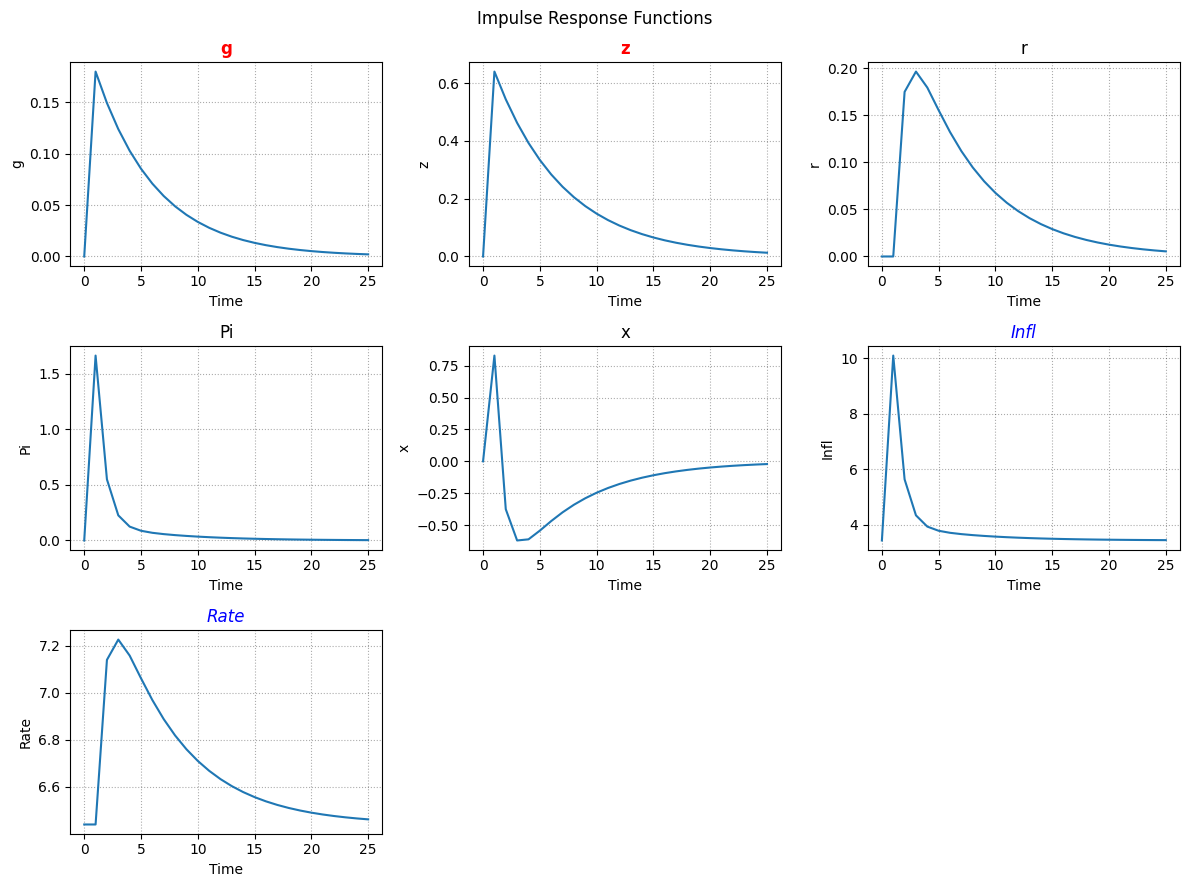

In [8]:
solved.transition_plot(25, ["g", "z"], 1.0, observables=True)

In [9]:
T = 200
g_shock = Shock(T, "norm", seed=0, dist_kwargs={"loc": 0.0}).shock_generator()
z_shock = Shock(T, "norm", seed=1, dist_kwargs={"loc": 0.0}).shock_generator()

sim_shocks = {"g": g_shock, "z": z_shock}

# sim_shocks = np.array([[1.0, 1.0], *np.zeros((24, 2))])
sol = solved.sim(T, sim_shocks, observables=True)

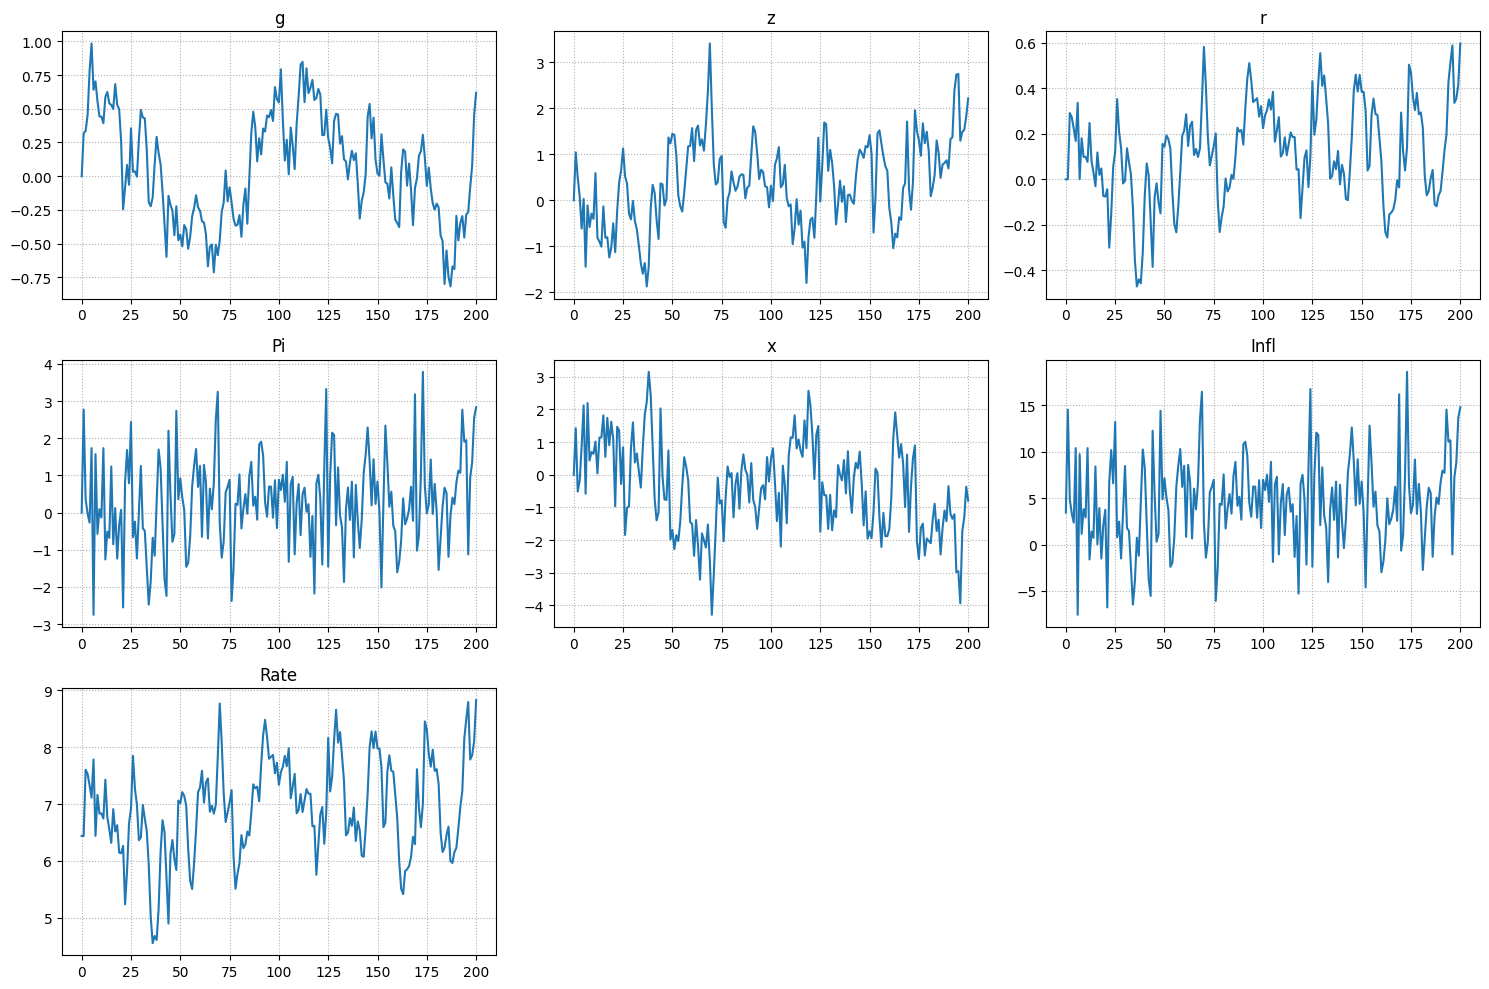

In [10]:
sol_plot = sol.copy()
del sol_plot["_X"]
n_plots = len(sol_plot)
dim = np.ceil(np.sqrt(n_plots)).astype(int)
fig, ax = plt.subplots(dim, dim, figsize=(15, 10))
ax = ax.flatten()
while len(ax) > n_plots:
    fig.delaxes(ax[-1])
    ax = ax[:-1]

for i, (var, series) in enumerate(sol_plot.items()):
    ax[i].plot(series)
    ax[i].set_title(var)
    ax[i].grid(linestyle=":")
plt.tight_layout()
plt.show()

In [18]:
# fred test
f = FRED(key_name="FRED_KEY")
df = f.get_frame(
    series_ids=["GDPC1", "CPIAUCSL", "FEDFUNDS"],
    date_range=("1960-01-01", "1997-10-01"),
)

In [19]:
time_idx = pd.date_range(start="1960-01-01", end="1997-10-01", freq="QS")
df = df.reindex(time_idx)
df

,GDPC1,CPIAUCSL,FEDFUNDS
1960-01-01,3517.181,29.37,3.99
1960-04-01,3498.246,29.54,3.92
1960-07-01,3515.385,29.55,3.23
1960-10-01,3470.278,29.75,2.47
1961-01-01,3493.703,29.84,1.45
...,...,...,...
1996-10-01,12037.775,158.20,5.24
1997-01-01,12115.472,159.40,5.25
1997-04-01,12317.221,159.90,5.51
1997-07-01,12471.010,160.40,5.52


In [20]:
# Convert to model units
df["GDPC1"] = 100 * (np.log(df["GDPC1"]) - HP_two_sided(np.log(df["GDPC1"]), 1600)[0])
df["CPIAUCSL"] = 400 * np.log((df["CPIAUCSL"] / df["CPIAUCSL"].shift(1)).dropna())

In [21]:
df = df.loc[df.index >= "1982-01-01"]

<Axes: >

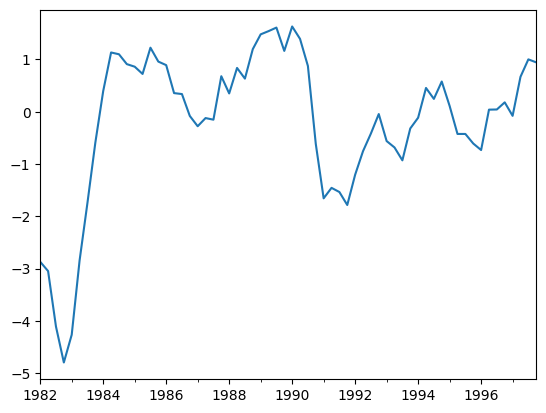

In [22]:
df.GDPC1.plot()

In [15]:
x0 = [0.0, 0.0, df["FEDFUNDS"].iloc[0], df["CPIAUCSL"].iloc[0], df["GDPC1"].iloc[0]]
solved.sim(T=df.shape[0], shocks=None, observables=True, x0=x0)

{'g': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'z': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'r': array([1.32200000e+01, 3.69103966e+00, 1.03054264e+00, 2.87728727e-01,
        8.03342012e-02, 2.24294041e-02, 6.26231620e-03, 1.74844610e-03,
        4.88168222e-04, 1.36297146e-04, 3.80543245e-05, 1.06248125e-05,
        2.96646022e-06, 8.28239208e-07, 2.31245368e-07, 6.45639806e-08,
        1.80263398e-08, 5.03297543e-09, 1.40521270e-09, 3.92337050e-10,
        1.09540969e-10, 3.05839683e-1